# Confinement Time Scaling Law on a Large GOLEM Dataset

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

The purpose of this notebook is to find a scaling law which fit the GOLEM shot confinement times. The data have been collected from shot #21000 to #29162 of the GOLEM shot database.

In [2]:
# open the shot database
dataset = pd.read_csv('close_shots.txt', delimiter='\s+', index_col='shots')
dataset['R'] = 0.4 # add the Vessel Major Radius column
dataset['a'] = 0.06 # add the Plasma minor Radius column

## Cleaning the data

Next we clean the data according to GOLEM team recommandations to avoid failed shot and NaN data:

In [3]:
print('Initial size of the dataset before cleaning: ', dataset.size)

# Drop vacuum shots
dataset = dataset.drop(dataset[dataset['plasma'] != 1].index)

# Drop plasma longer than 25 ms (not physical)
dataset = dataset.drop(dataset[dataset['plasma_life'] > 25e-3].index)

# Drop loop voltage below than 5V (not physical)
dataset = dataset.drop(dataset[dataset['loop_voltage_max'] < 5].index)

# Drop pressure larger than 100mPa
dataset = dataset.drop(dataset[dataset['pressure'] > 100].index)

# Drop shot which confinement time is negative
dataset = dataset.drop(dataset[dataset['electron_confinement_time'] <= 0].index)

# Drop shot which confinement time too high (not physical!)
dataset = dataset.drop(dataset[dataset['electron_confinement_time'] > 3e-4].index)

# Drop negative pressure request
dataset = dataset.drop(dataset[dataset['pressure_request'] < 0].index)

# Drop non physical ucd values
dataset = dataset.drop(dataset[dataset['ucd'] < 200].index)

# Drop non breakdown
dataset = dataset.drop(dataset[dataset['breakdown_probability'] == 0].index)

print('final size of the dataset after cleaning:', dataset.size)

Initial size of the dataset before cleaning:  374486
final size of the dataset after cleaning: 258658


## Confinement time scaling law

In this section we seek for the confinement scaling law in GOLEM. The general confinement time scaling law is:

$$
\tau = A I_p^a B_t^b P_{OH}^c n_e^d R^e 
$$

We recall that : 
$$
X^\alpha = e^{\alpha \log X}
$$

$$
\log (X^\alpha) = \alpha \log X
$$

So,
$$
\log\tau
= A' + a \log I_p + b\log B_t + c \log P_{OH} + d\log(n_e) + e\log(R)
$$

In the following, we are using the measured gaz pressure as a proxy of the electron density $n_e$, by using the signal "electron_density_equilibrium".  

In [4]:
# let's first filter only the usefull data from the whole dataset
dataset_sl = dataset[['electron_confinement_time', 'plasma_current_mean', 'toroidal_field_mean', 
                      'input_power_plasma_mean', 'pressure', 'R', 'electron_density_equilibrium']].copy()
dataset_sl['ne'] = dataset_sl['electron_density_equilibrium']/1e19

# Convert into log values and remove spurious points
dataset_sl_log = dataset_sl.apply(np.log).dropna()

# Make a linear regression on the log values
lin_reg = linear_model.LinearRegression()
lin_reg.fit(dataset_sl_log[['plasma_current_mean', 'toroidal_field_mean', 'input_power_plasma_mean', 'ne', 'R']], 
            dataset_sl_log[['electron_confinement_time']])
coefs = np.squeeze(lin_reg.coef_)

print(f'Scaling coefficients: a={coefs[0]:0.3f}, b={coefs[1]:0.3f}, c={coefs[2]:0.3f}, d={coefs[3]:0.3f}, e={coefs[4]:0.3f}')
print(f'Intersection A: {lin_reg.intercept_}')

Scaling coefficients: a=0.954, b=0.313, c=-1.327, d=1.040, e=-0.000
Intersection A: [-4.06500105]


<IPython.core.display.Javascript object>


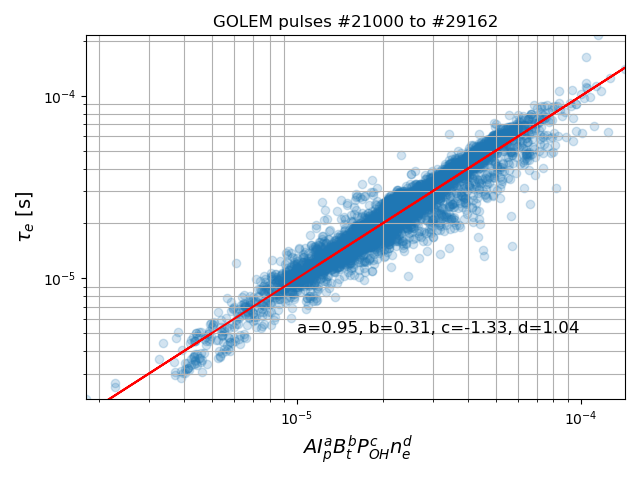

In [5]:
tau_scale = np.exp(lin_reg.intercept_) * \
        dataset_sl['plasma_current_mean']**coefs[0] * \
        dataset_sl['toroidal_field_mean']**coefs[1] * \
        dataset_sl['input_power_plasma_mean']**coefs[2] * \
        dataset_sl['ne']**coefs[3] * \
        dataset_sl['R']**coefs[4]

fig, ax = plt.subplots()
ax.scatter(tau_scale, dataset_sl['electron_confinement_time'], alpha=0.2)
ax.plot(tau_scale, tau_scale, color='r')
ax.set_xlim(np.amin(tau_scale), np.amax(tau_scale))
ax.set_ylim(dataset_sl['electron_confinement_time'].min(), dataset_sl['electron_confinement_time'].max())
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='minor')
ax.set_xlabel(r' $ A I_p^a B_t^b P_{OH}^c n_e^d $', fontsize=14)
ax.set_ylabel(r'$ \tau_e $ [s]', fontsize=14)
ax.text(1e-5, 5e-6, f'a={coefs[0]:0.2f}, b={coefs[1]:0.2f}, c={coefs[2]:0.2f}, d={coefs[3]:0.2f}', fontsize=12)
ax.set_title(f'GOLEM pulses #{dataset.index[0]} to #{dataset.index[-1]}')
fig.tight_layout()

fig.savefig('GOLEM_Tau_scaling_law.png')